In [180]:
import pandas as pd
import numpy as np
import os
import shutil
from collections import OrderedDict
from datetime import datetime, timedelta
import time
import math

import torch
from torch import nn, optim
import torch.nn.functional as F

from tqdm import tqdm

# Create Results Files

In [134]:
def create_results_files(comp_chart_path, results_path):
    '''
        Will grab the .2 file from each comprehensive chart directory
        
        Args:
            comp_chart_path (string): path to the comprehensive chart directories
            results_path (string): path to directory in which to save results files
            
        Returns:
            Nothing        
    '''
    chart_files = []
    for subdir, dirs, files in os.walk(comp_chart_path):
        for file in files:
            if file[-1] == '2':
                chart_files.append(subdir + '/' +file)
       
    # Delete files in results directory
    
    # Copy files
    for file in chart_files:
        shutil.copy(file, results_path)
            
create_results_files('./comp_chart_files/', './results_files/')

In [135]:
'''
# Add date to input file name
input_path = './drf/'
input_files = [input_path + file for file in os.listdir(input_path) if file.endswith(".DRF")]


for file in input_files:
    new_name = file[6:-4] + '2018.DRF'
    shutil.copy(file, './temp/{}'.format(new_name))
'''

'\n# Add date to input file name\ninput_path = \'./drf/\'\ninput_files = [input_path + file for file in os.listdir(input_path) if file.endswith(".DRF")]\n\n\nfor file in input_files:\n    new_name = file[6:-4] + \'2018.DRF\'\n    shutil.copy(file, \'./temp/{}\'.format(new_name))\n'

# Find All Pairs of Input/Results Files

In [136]:
def find_file_pairs(input_path, results_path):
    '''
        Find matching input/output files
        
        Args:
            input_path (string): relative path to input files
            results_path (string): relative path to results files
            
        Returns:
            (list) list of (input_file,results_file) pairs
    '''
    
    # Get a list of all input files and results files
    input_files = [input_path + file for file in os.listdir(input_path) if file.endswith(".DRF")]
    results_files = [results_path + file for file in os.listdir(results_path) if file.endswith('.2')]
    
    # Get names of files w/o directories/extensions
    input_names = sorted([file[len(input_path) : -4] for file in input_files])
    results_names = sorted([file[len(results_path) : -2] for file in results_files])
    
    # Find matches 
    matches = [name for name in input_names if name in results_names]
    
    # Create list of input/results file pairs -- [(input_file, results_file),(...),...]
    file_pairs = [('{}{}.DRF'.format(input_path, name), '{}{}.2'.format(results_path, name)) for name in matches]
    
    return file_pairs

file_pairs = find_file_pairs(input_path='./input_files/', results_path='./results_files/')

In [137]:
len(file_pairs)

402

# Add Number of Entrants to Files

In [138]:
def add_entrants(input_file, results_file):
    '''
        Find highest post position for each race and use as number of entrants
        
        Args:
            file (string): path to results file
            
        Returns:
            Nothing
    '''
    # Load files 
    input_df = pd.read_csv(input_file, header=None)
    res_df = pd.read_csv(results_file, header=None)
    
    # Find how many races are in each
    race_col = 2
    num_input_races = input_df[race_col].max()
    num_res_races = res_df[race_col].max()
    
    # TODO: Assert that race counts are equal
        
    # For each race, count entrants, append as last column
    input_last_col = input_df.columns.max() + 1
    race_entrants = {}
    for race in range(1,num_input_races+1):
        entrants = input_df.loc[input_df[race_col] == race].shape[0]
        iloc = input_df.loc[input_df[race_col] == race].index
        input_df.loc[iloc, input_last_col] = pd.Series(entrants, index=iloc)
        race_entrants[race] = entrants
        
    # Apply those same entrants numbers to results file
    res_last_col = res_df.columns.max() + 1
    for race in range(1, num_res_races+1):
        iloc = res_df.loc[res_df[race_col] == race].index
        res_df.loc[iloc, res_last_col] = pd.Series(race_entrants[race], index=iloc)
        
    # Save back to file
    input_df.to_csv(input_file, header=False, index=False)
    res_df.to_csv(results_file, header=False, index=False)

    
# Iterate through all files in file_pairs and add number of entrants
for pair in file_pairs:
    input_file = pair[0]
    res_file = pair[1]
    add_entrants(input_file, res_file)

# Parse Input and Results Files for Relevant Fields
These fields do not include past performance data -- these past performance fields will be handled by a separate process.

In [139]:
# Maps for input/results file structures -- colnum:colname
input_map = OrderedDict({
        1: 'date',
        2: 'race_num',
        3: 'post_pos',
        1435: 'num_entrants',
        44: 'horse_name',
        855: 'last_speed_rating',
        216: 'speed_par',
        33: 'app_weight_alw',
        100: 'lt_earnings',
        43: 'ml_odds',
        28: 'trainer_starts',
        29: 'trainer_wins',
        34: 'jockey_starts',
        35: 'jockey_wins'
    })

results_map = OrderedDict({
    1: 'date',
    2: 'race_num',
    4: 'horse_name',
    59: 'finish_pos', 
})

In [140]:
input_df = pd.DataFrame()
results_df = pd.DataFrame()

for pair in file_pairs:
    #Get input/results file names
    input_file = pair[0]
    results_file = pair[1]
    
    # Open files to dataframe -- Take only columns that are necessary
    input_cols = [k for k in input_map.keys()]
    results_cols = [k for k in results_map.keys()]
    input_tmp = pd.read_csv(input_file, header=None)[input_cols]
    results_tmp = pd.read_csv(results_file, header=None)[results_cols]
    
    # Rename cols
    input_tmp.columns = [input_map[col] for col in input_tmp.columns]
    results_tmp.columns = [results_map[col] for col in results_tmp.columns]
    
    # Add these inputs/results to dataframes
    input_df = input_df.append(input_tmp)
    results_df = results_df.append(results_tmp)
    
# Merge input and results dfs together -- convert horse_name to upper for results
results_df['horse_name'] = results_df['horse_name'].apply(lambda x: str(x).upper())
master_df = pd.merge(input_df, results_df,
                     how='left', left_on=['date', 'race_num', 'horse_name'],
                     right_on=['date','race_num', 'horse_name'])
master_df.head()

,date,race_num,post_pos,lt_earnings,app_weight_alw,ml_odds,horse_name,jockey_starts,jockey_wins,last_speed_rating,speed_par,num_entrants,trainer_starts,trainer_wins,finish_pos
0,20180506,1,1,31833,NaN,3.0,ITZ ALL GOOD,0,0,98.0,NaN,5.0,0,0,1.0
1,20180506,1,2,22706,NaN,1.6,STEEL PATRIOT,0,0,96.0,NaN,5.0,0,0,4.0
2,20180506,1,3,37294,NaN,2.5,DM AURORA,0,0,92.0,NaN,5.0,0,0,2.0
3,20180506,1,4,39885,NaN,4.5,ROUGE RIVER CARTEL,0,0,94.0,NaN,5.0,0,0,5.0
4,20180506,1,5,134484,NaN,2.0,RECKLESS AN WILD,0,0,97.0,NaN,5.0,0,0,3.0


In [142]:
def get_jockey_win_pct(df):
    df['jockey_win_pct'] = df['jockey_wins'] / df['jockey_starts']
    return df.drop(['jockey_wins', 'jockey_starts'], axis=1)

def get_trainer_win_pct(df):
    df['trainer_win_pct'] = df['trainer_wins'] / df['trainer_starts']
    return df.drop(['trainer_wins', 'trainer_starts'], axis=1)

# Calculate jockey/trainer win percentages
master_df = get_jockey_win_pct(master_df)
master_df = get_trainer_win_pct(master_df)

# Clean NaN cols
master_df = master_df.fillna(value=0)
master_df.head()

,date,race_num,post_pos,lt_earnings,app_weight_alw,ml_odds,horse_name,last_speed_rating,speed_par,num_entrants,finish_pos,jockey_win_pct,trainer_win_pct
0,20180506,1,1,31833,0.0,3.0,ITZ ALL GOOD,98.0,0.0,5.0,1.0,0.0,0.0
1,20180506,1,2,22706,0.0,1.6,STEEL PATRIOT,96.0,0.0,5.0,4.0,0.0,0.0
2,20180506,1,3,37294,0.0,2.5,DM AURORA,92.0,0.0,5.0,2.0,0.0,0.0
3,20180506,1,4,39885,0.0,4.5,ROUGE RIVER CARTEL,94.0,0.0,5.0,5.0,0.0,0.0
4,20180506,1,5,134484,0.0,2.0,RECKLESS AN WILD,97.0,0.0,5.0,3.0,0.0,0.0


# Get Past Performance Data

In [143]:
# Map for past performance fields
input_keys = OrderedDict({
    1: 'date',
    2: 'race_num',
    44: 'horse_name',
})

input_pp_map = OrderedDict({
    615 : 'pp_finish_pos',
    345 : 'pp_num_entrants',
    5: 'todays_distance',
    315: 'pp_distance',
    #535 : 'pp_race_class',
    255 : 'pp_race_date',
    1045: 'pp_claimed',
    1125: 'pp_favorite',
    605: 'pp_stretch_pos',
    113: 'pp_workout_time',
    465: 'pp_winners_margin'
})

#name_to_pp_col = OrderedDict({v:k for k,v in input_pp_map.items()})

In [144]:
def get_past_performance_data(input_files, num_races=3):
    '''
        Go through input files and get past performance data
        
        Args: 
            input_files (list): list of input file names 
            num_races (int): number of races back to grab data for
            
        Returns:
            pd.DataFrame with past performance data for each horse
    '''
    pp_df = pd.DataFrame()
    
    # Create new mapping for this number of races
    updated_pp_map = OrderedDict({k+race:'{}_{}'.format(v, race) for k,v in input_pp_map.items() for race in range(num_races)})
    
    for file in input_files:
        # Open input file to df
        df = pd.read_csv(file, header=None)
        
        # Only include key/past performance columns
        incl_cols = list(input_keys.keys()) + list(updated_pp_map.keys())
        df = df[incl_cols]
        
        # Rename columns
        renamed_cols = []
        for col in df.columns:
            try:
                # PP Column
                rn_col = updated_pp_map[col]
            except:
                # Key Column 
                rn_col = input_keys[col]    
            renamed_cols.append(rn_col)
        df.columns = renamed_cols
        
        # Append this file's df to pp_df
        pp_df = pp_df.append(df)
    
    return pp_df

input_files = [pair[0] for pair in file_pairs]
num_races = 3
pp_df = get_past_performance_data(input_files, num_races)
pp_df.head()

,date,race_num,horse_name,pp_race_date_1,pp_race_date_2,todays_distance_0,todays_distance_1,todays_distance_2,pp_winners_margin_0,pp_winners_margin_1,...,pp_finish_pos_1,pp_finish_pos_2,pp_favorite_2,pp_workout_time_0,pp_workout_time_1,pp_workout_time_2,pp_distance_0,pp_distance_1,pp_distance_2,pp_race_date_0
0,20180506,1,ITZ ALL GOOD,20171016.0,20171002.0,300,D,NaN,0.75,0.25,...,2,4,0.0,13.2,13.6,13.2,220.0,300.0,350.0,20171030.0
1,20180506,1,STEEL PATRIOT,20171009.0,20170911.0,300,D,NaN,0.25,0.25,...,7,1,0.0,13.8,13.2,12.0,400.0,440.0,330.0,20171030.0
2,20180506,1,DM AURORA,20171009.0,20170925.0,300,D,NaN,0.75,0.13,...,4,6,0.0,12.6,12.4,-13.2,350.0,350.0,300.0,20171023.0
3,20180506,1,ROUGE RIVER CARTEL,20171002.0,20170918.0,300,D,NaN,0.25,0.50,...,5,3,0.0,13.4,-12.2,13.2,400.0,350.0,330.0,20171030.0
4,20180506,1,RECKLESS AN WILD,20170720.0,20161017.0,300,D,NaN,0.50,0.50,...,1,4,0.0,12.6,13.4,13.2,350.0,330.0,350.0,20170810.0


# Clean Past Performance DataFrame

In [145]:
def clean_finish_pos_cols(pp_df, num_races=3):
        # Get finish position column names
        finish_pos_cols = ['pp_finish_pos_{}'.format(race) for race in range(num_races)]
        
        def clean_val(val):
            # If value is numeric, return its integer rep
            try:
                return int(val)
            except:
                # If value not numeric, return 0 (did not finish)
                return int(92)
            
        # Clean columns
        for col in finish_pos_cols:
            pp_df[col] = pp_df[col].apply(clean_val)
            
        return pp_df
    
def clean_stretch_pos_cols(pp_df, num_races=3):
        # Get stretch position column names
        stretch_pos_cols = ['pp_stretch_pos_{}'.format(race) for race in range(num_races)]
        
        def clean_val(val):
            # If value is numeric, return its integer rep
            try:
                return int(val)
            except:
                # If value not numeric, return 92 (did not finish)
                return int(92)
            
        
        # Clean columns
        for col in stretch_pos_cols:
            pp_df[col] = pp_df[col].apply(clean_val)
            
        return pp_df
    
def clean_favorite_cols(pp_df, num_races=3):
    def conv(val):
        if math.isnan(val):
            return int(0)
        else:
            return int(val)
        
    # Get favorite column names
    favorite_columns = ['pp_favorite_{}'.format(race) for race in range(num_races)]
    
    # Convert to integers
    for col in favorite_columns:
        pp_df[col] = pp_df[col].apply(conv)
        
    return pp_df
    
    
def clean_pp_df(pp_df, num_races=3):
    '''
        Clean fields in pp_df
        
        Args:
            pp_df (pd.DataFrame): dataframe to clean
            
        Returns:
            (pd.DataFrame) cleaned version of pp_df
    '''
    pp_df = clean_finish_pos_cols(pp_df, num_races)
    pp_df = clean_stretch_pos_cols(pp_df, num_races)
    pp_df = clean_favorite_cols(pp_df, num_races)
    
    return pp_df

pp_df = clean_pp_df(pp_df, num_races)
pp_df.head(10)

,date,race_num,horse_name,pp_race_date_1,pp_race_date_2,todays_distance_0,todays_distance_1,todays_distance_2,pp_winners_margin_0,pp_winners_margin_1,...,pp_finish_pos_1,pp_finish_pos_2,pp_favorite_2,pp_workout_time_0,pp_workout_time_1,pp_workout_time_2,pp_distance_0,pp_distance_1,pp_distance_2,pp_race_date_0
0,20180506,1,ITZ ALL GOOD,20171016.0,20171002.0,300,D,NaN,0.75,0.25,...,2,4,0,13.2,13.6,13.2,220.0,300.0,350.0,20171030.0
1,20180506,1,STEEL PATRIOT,20171009.0,20170911.0,300,D,NaN,0.25,0.25,...,7,1,0,13.8,13.2,12.0,400.0,440.0,330.0,20171030.0
2,20180506,1,DM AURORA,20171009.0,20170925.0,300,D,NaN,0.75,0.13,...,4,6,0,12.6,12.4,-13.2,350.0,350.0,300.0,20171023.0
3,20180506,1,ROUGE RIVER CARTEL,20171002.0,20170918.0,300,D,NaN,0.25,0.50,...,5,3,0,13.4,-12.2,13.2,400.0,350.0,330.0,20171030.0
4,20180506,1,RECKLESS AN WILD,20170720.0,20161017.0,300,D,NaN,0.50,0.50,...,1,4,0,12.6,13.4,13.2,350.0,330.0,350.0,20170810.0
5,20180506,2,TOO MUCH WHITE,20170918.0,20170813.0,220,D,NaN,0.13,0.50,...,92,1,0,12.2,14.0,13.8,350.0,400.0,330.0,20171023.0
6,20180506,2,JESS RIP,20171002.0,20170903.0,220,D,NaN,2.00,0.13,...,5,5,0,-12.2,12.4,13.6,350.0,250.0,300.0,20171030.0
7,20180506,2,JUNOIMZOOMIN,20170723.0,NaN,220,D,NaN,0.50,1.25,...,1,92,0,13.8,15.2,13.6,330.0,330.0,NaN,20170813.0
8,20180506,2,FLIRT WITH THE BOYZ,20170918.0,20170827.0,220,D,NaN,0.13,0.25,...,7,4,0,13.2,12.6,-13.4,250.0,350.0,300.0,20171030.0
9,20180506,2,GEORGIES MAY KITTY,20171016.0,20171002.0,220,D,NaN,2.00,0.06,...,2,3,0,13.6,12.8,14.0,350.0,400.0,250.0,20171030.0


# Derive Past Performance Metrics

In [146]:
def get_improved_finish_pos(pp_df, num_races=3):
    '''
        Calculate if horse is improving its finish position over the past races
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            
        Returns:
            (pd.DataFrame) an updated version of pp_df with a column for improved
            finish position
    '''
    
    def all_seq_vals_less_than_one(seq):
        ''' Returns true if all values in the passed sequence are <=1 '''
        for elt in seq:
            if elt > 1:
                return False
        return True

    # Get past finish pos cols
    finish_pos_cols = ['pp_finish_pos_{}'.format(race) for race in range(num_races)]
    # Concat all finish positions for each horse in a sequential list starting with most
    # recent race 
    finish_pos_seqs = pp_df[finish_pos_cols].values.tolist()
    
    imp_finish_pos = []
    for seq in finish_pos_seqs:
        # Skip any sequence where NaN appears
        if np.nan in seq:
            imp_finish_pos.append(False)
        # Skip any seq where horse didn't finish (fractional finish pos > 1)
        elif not all_seq_vals_less_than_one(seq):
            imp_finish_pos.append(False)
        else:
            # Determine if last finish was better than previous average finish
            most_recent = seq[0]
            avg_prev_finish = np.mean(seq[1:])
            imp_finish_pos.append(most_recent < avg_prev_finish)
            
    # Assign improved finish position series to pp_df
    pp_df['imp_finish_pos'] = pd.Series(imp_finish_pos)
    
    return pp_df

def get_recent_race(pp_df, threshold=21):
    '''
        Determine if a horse has had a previous race within threshold days
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            threshold (int): days to look back
            
        Returns:
            (pd.DataFrame) updated pp_df containing bool column stating whether
            each horse had a recent race or not
    '''
    
    def conv_date(val):
        # Set NaNs to 1970
        if math.isnan(float(val)):
            val = 19700101
        val = str(int(val))
        return datetime.strptime(val, '%Y%m%d')
    
    # Determine if race most recent race is within threshold
    pp_df['today'] = pp_df['date'].apply(conv_date)
    pp_df['last_race'] = pp_df['pp_race_date_0'].apply(conv_date)
    pp_df['timedelta'] = pd.Series(timedelta(days=threshold), index=pp_df.index)
    pp_df['cutoff'] = pp_df['today'] - pp_df['timedelta']
    pp_df['recent_race'] = pp_df['cutoff'] <= pp_df['last_race'] # Cutoff happened before last race
    
    # Drop intermediate columns
    drop_cols = ['today', 'last_race', 'timedelta', 'cutoff']
    return pp_df.drop(drop_cols, axis=1)
    
def get_past_finish_pos(pp_df, num_races=3):
    '''
        Calculate previous finish positions as finish_pos/num_entrants
        
        Args:
            pp_df (pd.DataFrame) past performance dataframe
            num_races (int): number of races for which we have past performance
        
        Returns:
            (pd.DataFrame) updated pp_df with finish positions calculated
    '''
    # Get finish position/entrants columns names
    finish_pos_cols = ['pp_finish_pos_{}'.format(race) for race in range(num_races)]
    entrants_cols = ['pp_num_entrants_{}'.format(race) for race in range(num_races)]
    cols = list(zip(finish_pos_cols, entrants_cols))
    
    # Divide finish pos by num entrants, save a raw copy of finish position
    for f_col, e_col in cols:
        pp_df['raw_'+f_col] = pp_df[f_col]
        pp_df[f_col] = pp_df[f_col] / pp_df[e_col]
    
    return pp_df

def get_claimed_in_past(pp_df, num_races=3):
    '''
        Determine if a horse was claimed in the past num_races
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            
        Returns:
            (pd.DataFrame) updated version of pp_df
    '''
    # Claimed column names
    claimed_cols = ['pp_claimed_{}'.format(race) for race in range(num_races)]
    claimed_seqs = pp_df[claimed_cols].values.tolist()
    
    # Determine if claimed in recent races    
    claimed = [True if 'c' in seq else False for seq in claimed_seqs]
    
    # Assign to pp_df
    pp_df['was_claimed'] = pd.Series(claimed, index=pp_df.index)
    
    return pp_df

def was_favorite(pp_df, num_races=3):
    '''
        Determine if a horse was the favorite in any of its recent races
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
    '''
    # Get favorite columns
    favorite_cols = ['pp_favorite_{}'.format(race) for race in range(num_races)]
    favorite_seqs = pp_df[favorite_cols].values.tolist()
    
    # If 1 in sequence, horse was favorite in recent race
    was_favorite = [True if 1 in seq else False for seq in favorite_seqs]
    
    pp_df['was_favorite'] = pd.Series(was_favorite, index=pp_df.index)
    
    return pp_df

def improved_stretch_pos(pp_df, num_races=3):
    '''
        Determine if a horse improved its finish position down the stretch in the most
        recent race
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
    '''
    # Stretch position columns
    stretch_pos_cols = ['pp_stretch_pos_{}'.format(race) for race in range(num_races)]
    
    # Get fractional stretch position
    pp_df['pp_stretch_pos'] = pp_df['pp_stretch_pos_0'] / pp_df['pp_num_entrants_0']
    
    # Determine if stretch pos > finish pos
    pp_df['improved_stretch_pos'] = pp_df['pp_stretch_pos'] > pp_df['pp_finish_pos_0']
    
    return pp_df.drop(['pp_stretch_pos'], axis=1)

def had_bullet_workout(pp_df, num_races=3):
    '''
        Determine if a horse had a bullet workout in previous workout
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
    '''
    # Get workout time columns
    workout_cols = ['pp_workout_time_{}'.format(race) for race in range(num_races)]
    
    # Determine if last workout was bullet
    pp_df['had_bullet'] = pp_df['pp_workout_time_0'] < 0
    
    return pp_df

def won_by_margin(pp_df, num_races=3, margin=5):
    '''
        Determine if a horse won last race by at least margin lengths
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            margin (float): number of lengths by which horse had to win
            
        Returns:
            (pd.DataFrame) updated version of pp_df
    '''
    # Find all winners of last race
    winners = pp_df.loc[pp_df.raw_pp_finish_pos_0 == 1]
    
    # Find all winners with at least margin length victory
    big_winners = winners.loc[winners.pp_winners_margin_0 >= margin].index
    
    # Create new col, default to false. Set True for all horses in big_winners index
    pp_df['won_by_margin'] = pd.Series(False, index=pp_df.index)
    pp_df.loc[big_winners, 'won_by_margin'] = True
    
    return pp_df

def won_at_similar_distance(pp_df, num_races=3):
    '''
        Determine if a horse won a recent race at the same distance as today's race
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            
        Returns:
            (pd.DataFrame) updated version of pp_df
    '''
    # Get distance and finish pos cols
    distance_cols = ['pp_distance_{}'.format(race) for race in range(num_races)]
    raw_finish_cols = ['raw_pp_finish_pos_{}'.format(race) for race in range(num_races)]
    
    # Find winners at similar distance by iterating through each recent race
    winners = []
    for race in range(num_races):
        dist_col = 'pp_distance_{}'.format(race)
        finish_col = 'raw_pp_finish_pos_{}'.format(race)
        today_dist_col = 'todays_distance_0'
        
        winners += pp_df.loc[(pp_df[dist_col] == pp_df[today_dist_col]) & (pp_df[finish_col] == 1)].index.tolist()
        
    # Create new column to denote if won at similar distance -- default False, True for 
    # horses in winners
    pp_df['won_at_similar_dist'] = pd.Series(False, index=pp_df.index)
    pp_df.loc[winners, 'won_at_similar_dist'] = True

    return pp_df
    
def derive_pp_metrics(pp_df, num_races=3):
    # Past Finish Positions
    pp_df = get_past_finish_pos(pp_df, num_races)
    # Improved Finish Position
    pp_df = get_improved_finish_pos(pp_df, num_races)
    # Recent race
    pp_df = get_recent_race(pp_df, 21)
    # Claimed in Past
    pp_df = get_claimed_in_past(pp_df, num_races)
    # Favorite in past
    pp_df = was_favorite(pp_df, num_races)
    # Improved stretch pos
    pp_df = improved_stretch_pos(pp_df, num_races)
    # Workout Rating
    pp_df = had_bullet_workout(pp_df, num_races)
    # Won last race by 5+ lengths
    pp_df = won_by_margin(pp_df, num_races, margin=4)
    # Won at similar distance
    pp_df = won_at_similar_distance(pp_df, num_races)    
    
    return pp_df
    
pp_df = derive_pp_metrics(pp_df)
pp_df.head()

,date,race_num,horse_name,pp_race_date_1,pp_race_date_2,todays_distance_0,todays_distance_1,todays_distance_2,pp_winners_margin_0,pp_winners_margin_1,...,raw_pp_finish_pos_1,raw_pp_finish_pos_2,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist
0,20180506,1,ITZ ALL GOOD,20171016.0,20171002.0,300,D,NaN,0.75,0.25,...,2,4,True,False,False,False,False,False,True,True
1,20180506,1,STEEL PATRIOT,20171009.0,20170911.0,300,D,NaN,0.25,0.25,...,7,1,True,False,False,True,False,False,True,True
2,20180506,1,DM AURORA,20171009.0,20170925.0,300,D,NaN,0.75,0.13,...,4,6,False,False,False,False,False,False,True,True
3,20180506,1,ROUGE RIVER CARTEL,20171002.0,20170918.0,300,D,NaN,0.25,0.50,...,5,3,False,False,False,False,False,False,True,True
4,20180506,1,RECKLESS AN WILD,20170720.0,20161017.0,300,D,NaN,0.50,0.50,...,1,4,True,False,False,True,True,False,True,True


# Clean Intermediate Derivation Columns

In [147]:
def clean_deriv_columns(pp_df, num_races=3):
    '''
        Drop all columns used as intermediates during feature derivation from pp_df
        
        Args:
            pp_df (pd.DataFrame): past performance dataframe
            num_races (int): number of races for which we have past performances
            
        Returns:
            (pd.DataFrame): a cleaned version of pp_df
    '''
    column_dict = {
        'claimed_cols' : ['pp_claimed_{}'.format(race) for race in range(num_races)],
        'date_cols' : ['pp_race_date_{}'.format(race) for race in range(num_races)],
        'distance_cols' : ['pp_distance_{}'.format(race) for race in range(num_races)],
        'entrants_cols' : ['pp_num_entrants_{}'.format(race) for race in range(num_races)],   
        'favorite_cols' : ['pp_favorite_{}'.format(race) for race in range(num_races)],
        'finish_pos_cols' : ['pp_finish_pos_{}'.format(race) for race in range(num_races)],
        'margin_cols' : ['pp_winners_margin_{}'.format(race) for race in range(num_races)],
        'raw_finish_cols' : ['raw_pp_finish_pos_{}'.format(race) for race in range(num_races)],
        'stretch_pos_cols' : ['pp_stretch_pos_{}'.format(race) for race in range(num_races)],
        'todays_distance_cols' : ['todays_distance_{}'.format(race) for race in range(num_races)],
        'workout_cols' : ['pp_workout_time_{}'.format(race) for race in range(num_races)],
    }
    
    for k, cols in column_dict.items():
        pp_df = pp_df.drop(cols, axis=1)
        
    return pp_df

pp_df = clean_deriv_columns(pp_df, num_races)
pp_df.head()

,date,race_num,horse_name,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist
0,20180506,1,ITZ ALL GOOD,True,False,False,False,False,False,True,True
1,20180506,1,STEEL PATRIOT,True,False,False,True,False,False,True,True
2,20180506,1,DM AURORA,False,False,False,False,False,False,True,True
3,20180506,1,ROUGE RIVER CARTEL,False,False,False,False,False,False,True,True
4,20180506,1,RECKLESS AN WILD,True,False,False,True,True,False,True,True


# Merge Past Performance with Master DF

In [148]:
master_df = pd.merge(master_df, pp_df,
                     how='left', left_on=['date', 'race_num', 'horse_name'],
                     right_on=['date','race_num', 'horse_name'])
master_df.head()

,date,race_num,post_pos,lt_earnings,app_weight_alw,ml_odds,horse_name,last_speed_rating,speed_par,num_entrants,...,jockey_win_pct,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist
0,20180506,1,1,31833,0.0,3.0,ITZ ALL GOOD,98.0,0.0,5.0,...,0.0,0.0,True,False,False,False,False,False,True,True
1,20180506,1,2,22706,0.0,1.6,STEEL PATRIOT,96.0,0.0,5.0,...,0.0,0.0,True,False,False,True,False,False,True,True
2,20180506,1,3,37294,0.0,2.5,DM AURORA,92.0,0.0,5.0,...,0.0,0.0,False,False,False,False,False,False,True,True
3,20180506,1,4,39885,0.0,4.5,ROUGE RIVER CARTEL,94.0,0.0,5.0,...,0.0,0.0,False,False,False,False,False,False,True,True
4,20180506,1,5,134484,0.0,2.0,RECKLESS AN WILD,97.0,0.0,5.0,...,0.0,0.0,True,False,False,True,True,False,True,True


# Add Label 

In [149]:
def add_label(master_df):
    master_df['label'] = master_df['finish_pos'] / master_df['num_entrants']
    return master_df

# Apply label
master_df = add_label(master_df)

# Drop all horses that did not finish (label == 0)
dnf_index = master_df.loc[master_df['label'] == 0].index
master_df = master_df.drop(dnf_index)
master_df.head(10)

,date,race_num,post_pos,lt_earnings,app_weight_alw,ml_odds,horse_name,last_speed_rating,speed_par,num_entrants,...,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist,label
0,20180506,1,1,31833,0.0,3.0,ITZ ALL GOOD,98.0,0.0,5.0,...,0.0,True,False,False,False,False,False,True,True,0.200000
1,20180506,1,2,22706,0.0,1.6,STEEL PATRIOT,96.0,0.0,5.0,...,0.0,True,False,False,True,False,False,True,True,0.800000
2,20180506,1,3,37294,0.0,2.5,DM AURORA,92.0,0.0,5.0,...,0.0,False,False,False,False,False,False,True,True,0.400000
3,20180506,1,4,39885,0.0,4.5,ROUGE RIVER CARTEL,94.0,0.0,5.0,...,0.0,False,False,False,False,False,False,True,True,1.000000
4,20180506,1,5,134484,0.0,2.0,RECKLESS AN WILD,97.0,0.0,5.0,...,0.0,True,False,False,True,True,False,True,True,0.600000
5,20180506,2,1,28496,0.0,2.5,TOO MUCH WHITE,94.0,0.0,6.0,...,0.0,False,False,False,False,False,False,True,True,0.833333
6,20180506,2,2,8292,0.0,3.5,JESS RIP,94.0,0.0,6.0,...,0.0,True,False,False,True,False,True,True,True,0.166667
7,20180506,2,3,14749,0.0,3.0,JUNOIMZOOMIN,95.0,0.0,6.0,...,0.0,False,False,False,True,False,False,True,True,0.666667
8,20180506,2,4,13662,0.0,5.0,FLIRT WITH THE BOYZ,97.0,0.0,6.0,...,0.0,True,False,False,False,False,False,True,True,1.000000
9,20180506,2,5,22840,0.0,10.0,GEORGIES MAY KITTY,94.0,0.0,6.0,...,0.0,True,False,False,False,True,False,True,True,0.500000


# Drop Columns Unused in Training

In [150]:
unused_cols = ['date', 'race_num', 'horse_name', 'finish_pos']
master_df = master_df.drop(unused_cols, axis=1)
master_df.head()

,post_pos,lt_earnings,app_weight_alw,ml_odds,last_speed_rating,speed_par,num_entrants,jockey_win_pct,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist,label
0,1,31833,0.0,3.0,98.0,0.0,5.0,0.0,0.0,True,False,False,False,False,False,True,True,0.2
1,2,22706,0.0,1.6,96.0,0.0,5.0,0.0,0.0,True,False,False,True,False,False,True,True,0.8
2,3,37294,0.0,2.5,92.0,0.0,5.0,0.0,0.0,False,False,False,False,False,False,True,True,0.4
3,4,39885,0.0,4.5,94.0,0.0,5.0,0.0,0.0,False,False,False,False,False,False,True,True,1.0
4,5,134484,0.0,2.0,97.0,0.0,5.0,0.0,0.0,True,False,False,True,True,False,True,True,0.6


# Convert Boolean Columns to Binary

In [151]:
bool_cols = ['imp_finish_pos', 'recent_race', 'was_claimed','was_favorite', \
             'improved_stretch_pos', 'had_bullet', 'won_by_margin', \
             'won_at_similar_dist']

for col in bool_cols:
    master_df[col] = master_df[col].apply(lambda x: int(x))

master_df.head()

,post_pos,lt_earnings,app_weight_alw,ml_odds,last_speed_rating,speed_par,num_entrants,jockey_win_pct,trainer_win_pct,imp_finish_pos,recent_race,was_claimed,was_favorite,improved_stretch_pos,had_bullet,won_by_margin,won_at_similar_dist,label
0,1,31833,0.0,3.0,98.0,0.0,5.0,0.0,0.0,1,0,0,0,0,0,1,1,0.2
1,2,22706,0.0,1.6,96.0,0.0,5.0,0.0,0.0,1,0,0,1,0,0,1,1,0.8
2,3,37294,0.0,2.5,92.0,0.0,5.0,0.0,0.0,0,0,0,0,0,0,1,1,0.4
3,4,39885,0.0,4.5,94.0,0.0,5.0,0.0,0.0,0,0,0,0,0,0,1,1,1.0
4,5,134484,0.0,2.0,97.0,0.0,5.0,0.0,0.0,1,0,0,1,1,0,1,1,0.6


# Create Dataloader
This will return the training data and the label data

In [152]:
from sklearn.utils import shuffle as df_shuffle

def dataloader(df, shuffle=True):
    if shuffle:
            df = df_shuffle(df)
    
    # Get labels and data
    labels = df['label']
    data = df.drop(['label'], axis=1)
            
    # Turn data and label into tensor
    for ii in range(len(data)):        
        yield torch.tensor(data.iloc[ii]), torch.tensor(labels.iloc[ii])

In [153]:
# Test dataloader
sample_data, sample_label = next(iter(dataloader(master_df)))
print(sample_data, sample_label)

tensor([5.0000e+00, 1.3208e+05, 0.0000e+00, 2.0000e+01, 6.5000e+01, 8.7000e+01,
        8.0000e+00, 5.2632e-02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]) tensor(0.5000)


# Create Test/Training Sets

In [154]:
train_prop = 0.8 # Proportion of training data to testing data
train_end_idx = int(len(master_df) * 0.8)

train_data = master_df.loc[:train_end_idx,:].copy()
test_data = master_df.loc[train_end_idx:,:].copy()

# Standardize Test/Training Sets

In [155]:
def standardize_series(s):
    return (s - s.mean()) / s.std()

# Standardize training data
for col in train_data.columns:
    if col != 'label':
        train_data.loc[:,col] = standardize_series(train_data[col])

# Standardize testing data
for col in test_data.columns:
    if col != 'label':
        test_data.loc[:, col] = standardize_series(test_data[col])
    
# Ensure standardization
#print(train_data.mean(), train_data.std())
#print(test_data.mean(), test_data.std())

# Define the Model

In [195]:
input_features = train_data.shape[1] - 1 # Don't count label column
output_size = 1
drop_prob = 0.3

model = nn.Sequential(
    nn.Linear(input_features, 512),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(256, output_size),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=17, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3)
  (6): Linear(in_features=256, out_features=1, bias=True)
  (7): Sigmoid()
)


# Train Model

In [196]:
# Start Time
start_time = time.time()

# Use GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define Training/Validation Loop
epochs = 5
lr = 0.00001
print_every = 50
clip = 5

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

training_losses = [x for x in range(epochs)]
validation_losses = [x for x in range(epochs)]

# Save metrics
lowest_val_loss=100
today = datetime.strftime(datetime.now(), '%Y%m%d')

for epoch in range(epochs):
    print('Starting Epoch {}'.format(epoch+1))
    entries_processed = 0
    
    # Begin Training Loop
    train_losses = []
    val_losses = []
    for data, label in dataloader(train_data):
        entries_processed += 1
        
        # Set tensors to correct device
        data, label = data.to(device), label.to(device)
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Perform pass through network
        train_out = model(data)
        
        # Calculate Loss and perform backprop -- clip gradients if necessary
        train_loss = criterion(train_out, label)
        train_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Log Loss
        train_losses.append(train_loss.item())
    
        # Take optimizer step
        optimizer.step()
        
        if entries_processed % print_every == 0:
            # Validation loop
            model.eval()
            for data, label in dataloader(test_data):
                # Set tensors to correct device
                data, label = data.to(device), label.to(device)
                
                # Generate prediction
                val_out = model(data)
                
                # Calculate and log loss
                val_loss = criterion(val_out, label)
                val_losses.append(val_loss.item())
                
            # Set back to training mode
            model.train()
                
            # If this iteration has lowest validation loss, save model
            if np.mean(val_losses) < lowest_val_loss:
                torch.save(model, './models/linear-model-{}e-{}.pth'.format(epochs, today))
                
            # Print Metrics
            print(
                'Epoch: {}/{}...'.format(epoch+1, epochs),
                'Entries Processed: {}...'.format(entries_processed),
                'Training Loss: {:.6f}...'.format(np.mean(train_losses)),
                'Validation Loss: {:.6f}...'.format(np.mean(val_losses))
                 )
            
        # Log Epoch-level metrics
        training_losses[epoch] = np.mean(train_losses)
        validation_losses[epoch] = np.mean(val_losses)
        
# End Time
end_time = time.time() - start_time
print('Elapsed Time: {} Minutes'.format(end_time//60))

Starting Epoch 1


/Users/nate/anaconda3/envs/julie-stav-ws/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nate/anaconda3/envs/julie-stav-ws/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1/5... Entries Processed: 50... Training Loss: 0.091198... Validation Loss: 0.074777...
Epoch: 1/5... Entries Processed: 100... Training Loss: 0.077709... Validation Loss: 0.074777...
Epoch: 1/5... Entries Processed: 150... Training Loss: 0.071854... Validation Loss: 0.074661...
Epoch: 1/5... Entries Processed: 200... Training Loss: 0.071083... Validation Loss: 0.074585...
Epoch: 1/5... Entries Processed: 250... Training Loss: 0.073658... Validation Loss: 0.074434...


KeyboardInterrupt: 

# Plot Performance

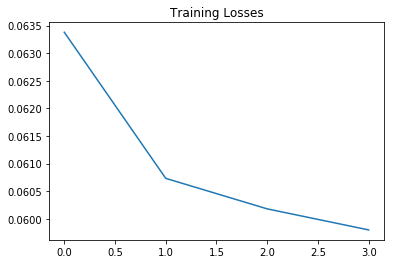

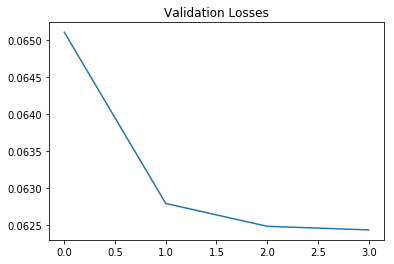

In [194]:
import matplotlib.pyplot as plt

# Plot training losses
plt.title('Training Losses')
plt.plot(training_losses[:4])
plt.show()

# Plot Validation Losses
plt.title('Validation Losses')
plt.plot(validation_losses[:4])
plt.show() 

# Save the Model

In [29]:
torch.save(model, './models/linear-model-5e.pth')

# Load and Test Model

In [188]:
loaded_model = torch.load('./models/linear-model-8e-20190501.pth')

# Evaluate model
loaded_model = loaded_model.to(device)
model.eval()
element = 98

for element in range(0, len(test_data)):
    if element % 10 == 0:
        data = torch.tensor(test_data.iloc[element,:-1]).to(device)
        label = torch.tensor(test_data.iloc[element, -1]).to(device)

        prediction = loaded_model(data)
        loss = criterion(prediction, label)

        print(prediction, label, loss.item())

tensor([0.4724], grad_fn=<SigmoidBackward>) tensor(0.7778) 0.09324448555707932
tensor([0.6198], grad_fn=<SigmoidBackward>) tensor(0.2500) 0.13673928380012512
tensor([0.3597], grad_fn=<SigmoidBackward>) tensor(0.1111) 0.061803147196769714
tensor([0.6748], grad_fn=<SigmoidBackward>) tensor(0.8750) 0.040061984211206436
tensor([0.4975], grad_fn=<SigmoidBackward>) tensor(0.1250) 0.13874535262584686
tensor([0.7695], grad_fn=<SigmoidBackward>) tensor(1.) 0.0531235933303833
tensor([0.4710], grad_fn=<SigmoidBackward>) tensor(0.1250) 0.11974690854549408
tensor([0.5150], grad_fn=<SigmoidBackward>) tensor(0.3000) 0.04621150717139244
tensor([0.7233], grad_fn=<SigmoidBackward>) tensor(0.4444) 0.07773594558238983
tensor([0.5410], grad_fn=<SigmoidBackward>) tensor(0.6667) 0.01579822599887848
tensor([0.4496], grad_fn=<SigmoidBackward>) tensor(0.1429) 0.0940626934170723
tensor([0.3485], grad_fn=<SigmoidBackward>) tensor(0.2000) 0.02203790657222271
tensor([0.3574], grad_fn=<SigmoidBackward>) tensor(0.300

tensor([0.7023], grad_fn=<SigmoidBackward>) tensor(0.5714) 0.017135659232735634
tensor([0.4878], grad_fn=<SigmoidBackward>) tensor(0.2857) 0.040840763598680496
tensor([0.4604], grad_fn=<SigmoidBackward>) tensor(1.) 0.2911338806152344
tensor([0.5445], grad_fn=<SigmoidBackward>) tensor(0.4286) 0.013429662212729454
tensor([0.4090], grad_fn=<SigmoidBackward>) tensor(0.1429) 0.07084648311138153
tensor([0.6239], grad_fn=<SigmoidBackward>) tensor(0.3750) 0.06195376068353653
tensor([0.4868], grad_fn=<SigmoidBackward>) tensor(0.6667) 0.03236624598503113
tensor([0.4696], grad_fn=<SigmoidBackward>) tensor(0.8889) 0.17577634751796722
tensor([0.3156], grad_fn=<SigmoidBackward>) tensor(0.5000) 0.034002721309661865
tensor([0.4768], grad_fn=<SigmoidBackward>) tensor(0.7500) 0.07463297992944717
tensor([0.5860], grad_fn=<SigmoidBackward>) tensor(0.2500) 0.11290214210748672
tensor([0.4449], grad_fn=<SigmoidBackward>) tensor(0.1429) 0.09120366722345352
tensor([0.4758], grad_fn=<SigmoidBackward>) tensor(0.

tensor([0.6213], grad_fn=<SigmoidBackward>) tensor(1.) 0.1434154212474823
tensor([0.4200], grad_fn=<SigmoidBackward>) tensor(0.2857) 0.0180253554135561
tensor([0.6180], grad_fn=<SigmoidBackward>) tensor(0.6667) 0.002372819697484374
tensor([0.8373], grad_fn=<SigmoidBackward>) tensor(0.8750) 0.0014211010420694947
tensor([0.3535], grad_fn=<SigmoidBackward>) tensor(0.2727) 0.006517740432173014
tensor([0.3977], grad_fn=<SigmoidBackward>) tensor(0.3000) 0.009544812142848969
tensor([0.7710], grad_fn=<SigmoidBackward>) tensor(1.) 0.05243790149688721
tensor([0.7479], grad_fn=<SigmoidBackward>) tensor(0.7500) 4.241619535605423e-06
tensor([0.3912], grad_fn=<SigmoidBackward>) tensor(0.2500) 0.019942238926887512
tensor([0.5062], grad_fn=<SigmoidBackward>) tensor(0.3000) 0.042519424110651016
tensor([0.5228], grad_fn=<SigmoidBackward>) tensor(0.8571) 0.11176799237728119
tensor([0.5465], grad_fn=<SigmoidBackward>) tensor(0.3333) 0.0454438216984272
tensor([0.3939], grad_fn=<SigmoidBackward>) tensor(0.5

tensor([0.3329], grad_fn=<SigmoidBackward>) tensor(0.1111) 0.04918595775961876
tensor([0.3851], grad_fn=<SigmoidBackward>) tensor(0.7000) 0.09918303787708282
tensor([0.3597], grad_fn=<SigmoidBackward>) tensor(0.4444) 0.007187119219452143
tensor([0.4836], grad_fn=<SigmoidBackward>) tensor(0.5000) 0.00026834383606910706
tensor([0.5024], grad_fn=<SigmoidBackward>) tensor(0.7500) 0.06130275875329971
tensor([0.7544], grad_fn=<SigmoidBackward>) tensor(0.2222) 0.2832172214984894
tensor([0.4451], grad_fn=<SigmoidBackward>) tensor(0.5714) 0.015963226556777954
tensor([0.4974], grad_fn=<SigmoidBackward>) tensor(0.1429) 0.12571334838867188
tensor([0.4413], grad_fn=<SigmoidBackward>) tensor(0.4286) 0.000162532101967372
tensor([0.4408], grad_fn=<SigmoidBackward>) tensor(0.8571) 0.1733763962984085
tensor([0.7176], grad_fn=<SigmoidBackward>) tensor(0.4000) 0.10089246928691864
tensor([0.6299], grad_fn=<SigmoidBackward>) tensor(0.8000) 0.02893608994781971
tensor([0.4478], grad_fn=<SigmoidBackward>) tens

tensor([0.6948], grad_fn=<SigmoidBackward>) tensor(0.6250) 0.004876620136201382
tensor([0.5780], grad_fn=<SigmoidBackward>) tensor(1.) 0.1780555248260498
tensor([0.6402], grad_fn=<SigmoidBackward>) tensor(0.7500) 0.012057933956384659
tensor([0.4516], grad_fn=<SigmoidBackward>) tensor(1.) 0.30076849460601807
tensor([0.3856], grad_fn=<SigmoidBackward>) tensor(0.5556) 0.02888191118836403
tensor([0.4794], grad_fn=<SigmoidBackward>) tensor(0.6000) 0.014540065079927444
tensor([0.4137], grad_fn=<SigmoidBackward>) tensor(0.4286) 0.0002222898037871346
tensor([0.5280], grad_fn=<SigmoidBackward>) tensor(0.7692) 0.058215126395225525
tensor([0.5819], grad_fn=<SigmoidBackward>) tensor(1.) 0.17477142810821533
tensor([0.5996], grad_fn=<SigmoidBackward>) tensor(0.8000) 0.04014198109507561
tensor([0.5477], grad_fn=<SigmoidBackward>) tensor(0.2500) 0.0886189341545105
tensor([0.5101], grad_fn=<SigmoidBackward>) tensor(0.5000) 0.00010122064122697338
tensor([0.6002], grad_fn=<SigmoidBackward>) tensor(0.8889